In [1]:
%matplotlib qt
#%matplotlib inline

In [2]:
# Materials used to prepare this demo:
    # - EEG Data Processing: https://neuro.inf.unibe.ch/AlgorithmsNeuroscience/Tutorial_files/DataVisualization.html
    # - MNE Artifacts removal tutorial: https://mne.tools/dev/auto_tutorials/preprocessing/plot_40_artifact_correction_ica.html#sphx-glr-auto-tutorials-preprocessing-plot-40-artifact-correction-ica-py
    # - MNE Time-Frequency tutorial: https://mne.tools/dev/auto_examples/time_frequency/plot_time_frequency_erds.html#sphx-glr-auto-examples-time-frequency-plot-time-frequency-erds-py

In [2]:
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import mne.viz
import os
import os.path as op
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
import numpy as np
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.datasets import fetch_fsaverage

from warnings import simplefilter
#ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Load dataset & plot raw data 

Extracting EDF parameters from /Users/marieconstance.corsi/Documents/GitHub/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/marieconstance.corsi/Documents/GitHub/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/marieconstance.corsi/Documents/GitHub/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Number of channels:  64
Number of samples:  60000
Using matplotl

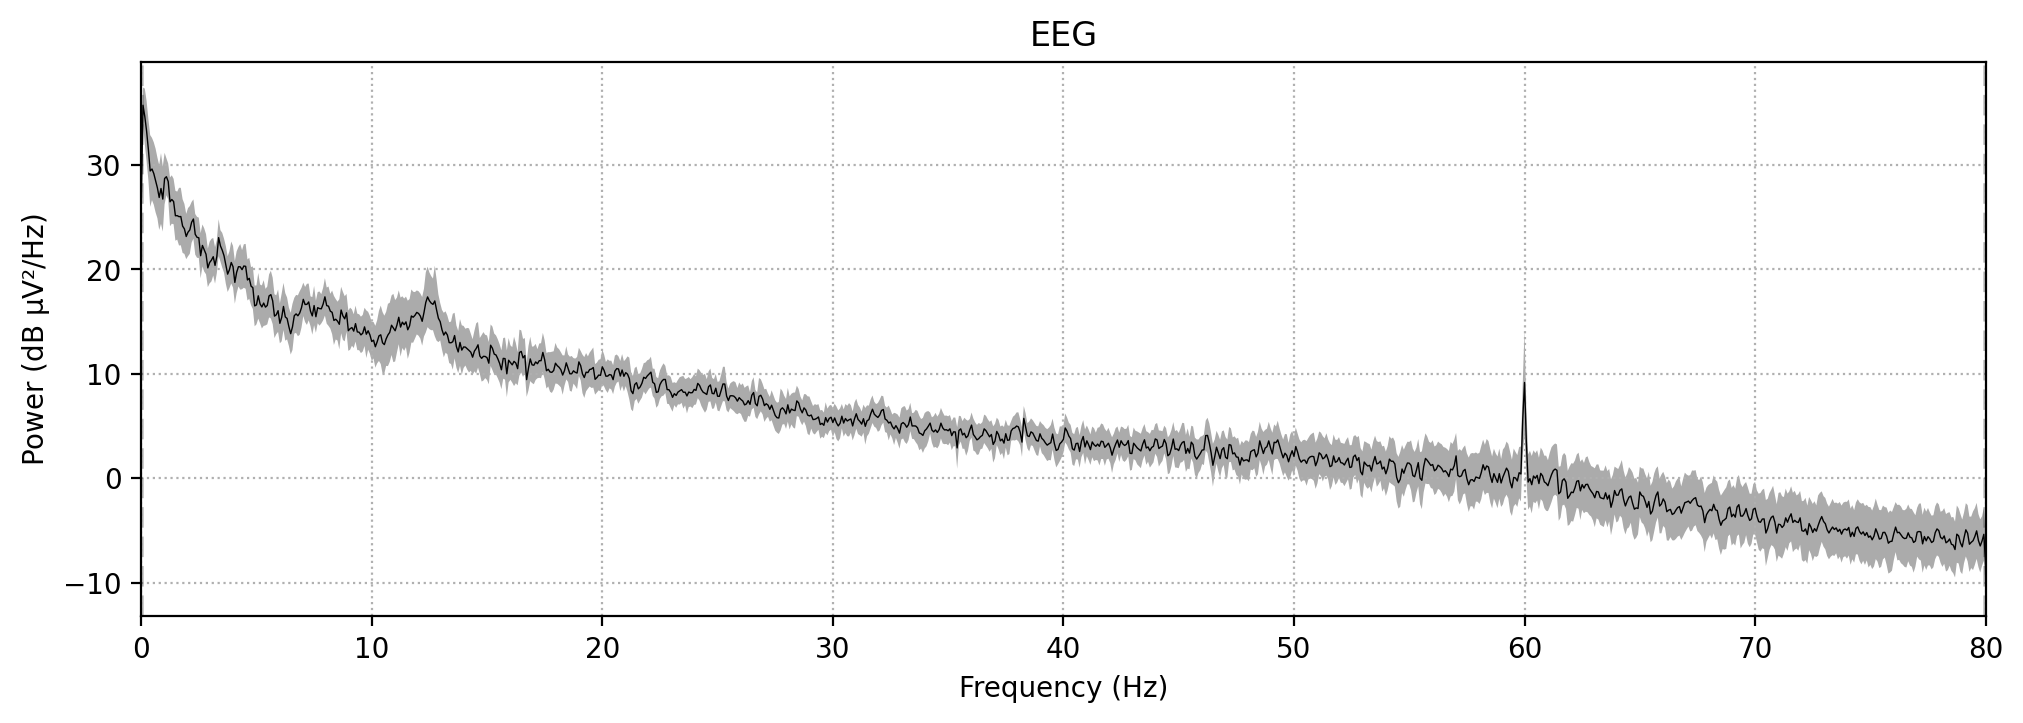

In [3]:
#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # use only hand and feet motor imagery runs

#Get data and locate in to given path
files = eegbci.load_data(subject, runs, '../datasets/')
#Read raw data files where each file contains a run
raws = [read_raw_edf(f, preload=True) for f in files]
#Combine all loaded runs
raw_obj = concatenate_raws(raws)

raw_data = raw_obj.get_data()
print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data[0])))

#Plot epochs & PSD
raw_obj.plot(duration=120, n_channels=15, scalings=dict(eeg=420e-6))
raw_obj.plot_psd(average=True)

# Artifacts removal

In [5]:
# Compute ICA components
mapping = {
    'Fc5.': 'FC5', 'Fc3.': 'FC3', 'Fc1.': 'FC1', 'Fcz.': 'FCz', 'Fc2.': 'FC2',
    'Fc4.': 'FC4', 'Fc6.': 'FC6', 'C5..': 'C5', 'C3..': 'C3', 'C1..': 'C1',
    'Cz..': 'Cz', 'C2..': 'C2', 'C4..': 'C4', 'C6..': 'C6', 'Cp5.': 'CP5',
    'Cp3.': 'CP3', 'Cp1.': 'CP1', 'Cpz.': 'CPz', 'Cp2.': 'CP2', 'Cp4.': 'CP4',
    'Cp6.': 'CP6', 'Fp1.': 'Fp1', 'Fpz.': 'Fpz', 'Fp2.': 'Fp2', 'Af7.': 'AF7',
    'Af3.': 'AF3', 'Afz.': 'AFz', 'Af4.': 'AF4', 'Af8.': 'AF8', 'F7..': 'F7',
    'F5..': 'F5', 'F3..': 'F3', 'F1..': 'F1', 'Fz..': 'Fz', 'F2..': 'F2',
    'F4..': 'F4', 'F6..': 'F6', 'F8..': 'F8', 'Ft7.': 'FT7', 'Ft8.': 'FT8',
    'T7..': 'T7', 'T8..': 'T8', 'T9..': 'T9', 'T10.': 'T10', 'Tp7.': 'TP7',
    'Tp8.': 'TP8', 'P7..': 'P7', 'P5..': 'P5', 'P3..': 'P3', 'P1..': 'P1',
    'Pz..': 'Pz', 'P2..': 'P2', 'P4..': 'P4', 'P6..': 'P6', 'P8..': 'P8',
    'Po7.': 'PO7', 'Po3.': 'PO3', 'Poz.': 'POz', 'Po4.': 'PO4', 'Po8.': 'PO8',
    'O1..': 'O1', 'Oz..': 'Oz', 'O2..': 'O2', 'Iz..': 'Iz'
}

raws = list()
icas = list()

for subj in range(4):
    # EEGBCI subjects are 1-indexed; run 3 is a left/right hand movement task
    fname = mne.datasets.eegbci.load_data(subj + 1, runs=[3])[0]
    raw = mne.io.read_raw_edf(fname, preload=True)
    # remove trailing `.` from channel names so we can set montage
    raw.rename_channels(mapping)
    raw.set_montage('standard_1005')

    # fit ICA
    ica = ICA(n_components=30, random_state=97)
    ica.fit(raw)
    raws.append(raw)
    icas.append(ica)


Extracting EDF parameters from /Users/marieconstance.corsi/Documents/GitHub/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 30 components


/var/folders/d4/_4q888f9053cl142j5r3tmy00000gq/T/ipykernel_92847/4053033420.py:31: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.6s.
Extracting EDF parameters from /Users/marieconstance.corsi/Documents/GitHub/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 30 components


/var/folders/d4/_4q888f9053cl142j5r3tmy00000gq/T/ipykernel_92847/4053033420.py:31: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.1s.
Extracting EDF parameters from /Users/marieconstance.corsi/Documents/GitHub/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 30 components


/var/folders/d4/_4q888f9053cl142j5r3tmy00000gq/T/ipykernel_92847/4053033420.py:31: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.9s.
Extracting EDF parameters from /Users/marieconstance.corsi/Documents/GitHub/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 30 components


/var/folders/d4/_4q888f9053cl142j5r3tmy00000gq/T/ipykernel_92847/4053033420.py:31: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.8s.


In [6]:
# use the first subject as template; use Fpz as proxy for EOG
raw = raws[0]
ica = icas[0]
eog_inds, eog_scores = ica.find_bads_eog(raw, ch_name='Fpz')
corrmap(icas, template=(0, eog_inds[0]))

for index, (ica, raw) in enumerate(zip(icas, raws)):
    fig = ica.plot_sources(raw, show_scrollbars=False)
    fig.subplots_adjust(top=0.9)  # make space for title
    fig.suptitle('Subject {}'.format(index))



Using EOG channel: Fpz
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1600 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Median correlation with constructed map: 0.959
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Creating RawArray with float64 data, n_channels=30, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Creating RawArray with float64 data, n_channels=30, n_times=19680
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Creating RawArray with float64 data, n_channels=30, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Creating RawArray with float64 data, n_channels=30, n_times=19680
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.


In [7]:
# compute correlations between ICA components and blinks - automatic detection labeled as "blinks"
corrmap(icas, template=(0, eog_inds[0]), threshold=0.9)

corrmap(icas, template=(0, eog_inds[0]), threshold=0.9, label='blink',
        plot=False)
print([ica.labels_ for ica in icas])


Median correlation with constructed map: 0.944
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.944
At least 1 IC detected for each subject.
[{'eog/0/Fpz': [0], 'eog': [0], 'blink': [0]}, {'blink': [0]}, {'blink': [0]}, {'blink': [0, 2]}]


In [8]:
# Example of artifact detection & rejection, for a given subject
icas[3].plot_components(picks=icas[3].labels_['blink'])
icas[3].exclude = icas[3].labels_['blink']
icas[3].plot_sources(raws[3], show_scrollbars=False)
raw_preproc = raws[3].copy()
icas[3].apply(raw_preproc) # remove the bad components
raw_preproc.plot() # preprocessed data

template_eog_component = icas[0].get_components()[:, eog_inds[0]]
corrmap(icas, template=template_eog_component, threshold=0.9)
print(template_eog_component)

Creating RawArray with float64 data, n_channels=30, n_times=19680
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Median correlation with constructed map: 0.944
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
[-0.44495318 -0.40983842 -0.38930046 -0.37648581 -0.4081585  -0.43522276
 -0.47475364 -0.29240548 -0.28406613 -0.26882023 -0.25526935 -0.28871567
 -0.30326613 -0.30316262 -0.21016141 -0.22111437 -0.21807985 -0.207049
 -0.22375209 -0.24014921 -0.25321907 -1.68027772 -1.4824676  -1.62847163
 -1.40547681 -1.36613268 -0.85900872 -1.07936549 -1.52916767 -0.69233214
 -0.77286864 -0.65947637 -0.61444207 -0.59479909 -0.64739204 -0.65451653
 -0.76721442 -0.78455491 -0.38975992 -0.43540168 -0.24198818 -0.29395946
 -0.12909375 -0.16455719 -0.17778243 -0.18440583 -0.13619307 -0.16361049
 -0.17566436

# Quality check

In [9]:
# plot properties of the first component - automatically detected as "blink"
ica.plot_properties(raw, picks=[0])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 1400x1200 with 6 Axes>]

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


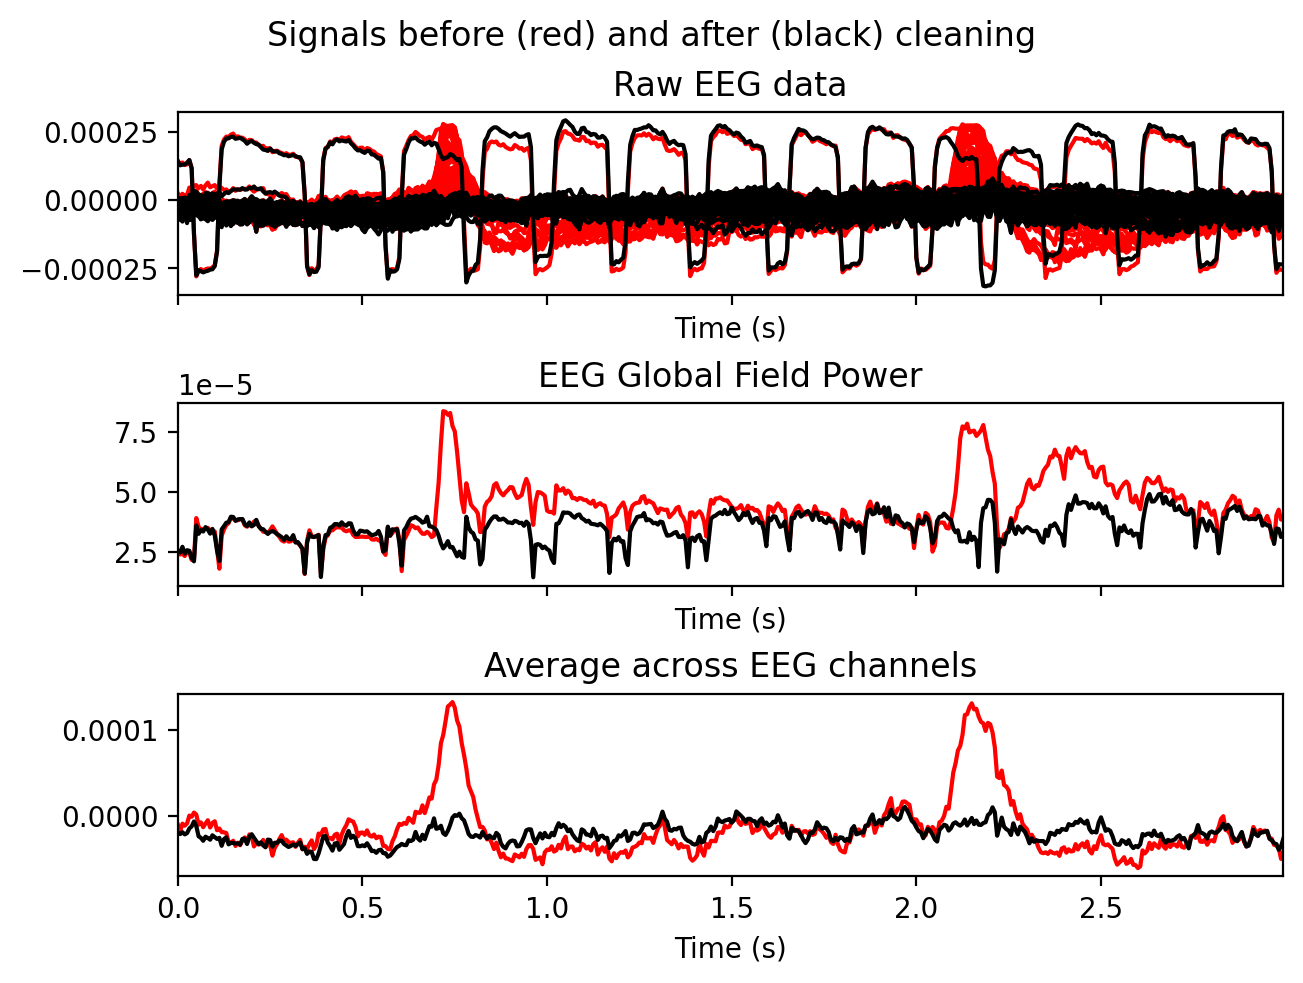

In [10]:
# blinks
ica.plot_overlay(raw, exclude=[0], picks="eeg")

# Analysis

In [11]:
## Compute ERD/S maps to elicit potential desynchronization effect
events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))
picks = mne.pick_channels(raw.info["ch_names"], ["C3", "Cz", "C4"])

# epoch data
tmin, tmax = -1, 4  # define epochs around events (in s)
event_ids = dict(hands=2, feet=3)  # map event IDs to tasks

epochs = mne.Epochs(raw, events, event_ids, tmin - 0.5, tmax + 0.5,
                    picks=picks, baseline=None, preload=True)

# compute ERDS maps
freqs = np.arange(2, 36, 1)  # frequencies from 2-35Hz
n_cycles = freqs  # use constant t/f resolution
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1, 0)  # baseline interval (in s)
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test

# Run TF decomposition overall epochs
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
                     use_fft=True, return_itc=False, average=False,
                     decim=2)
tfr.crop(tmin, tmax)
tfr.apply_baseline(baseline, mode="percent")
for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=-1,
                                     **kwargs)
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], vmin=vmin, vmax=vmax, cmap="RdBu_r",
                              axes=ax, colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1])
    fig.suptitle("ERDS ({})".format(event))
    fig.show()


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 961 original time points ...
1 bad epochs dropped
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Using a threshold of 1.943180
stat_fun(H1): min=-18.822072719150636 max=4.895635497626151
Running initial clustering …
Found 73 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.943180
stat_fun(H1): min=-18.822072719150636 max=4.895635497626151
Running initial clustering …
Found 132 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 1 additional cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.943180
stat_fun(H1): min=-13.90428875648746 max=4.816889913404437
Running initial clustering …
Found 62 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.943180
stat_fun(H1): min=-13.90428875648746 max=4.816889913404437
Running initial clustering …
Found 96 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.943180
stat_fun(H1): min=-18.592672348321692 max=7.577033819772394
Running initial clustering …
Found 72 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.943180
stat_fun(H1): min=-18.592672348321692 max=7.577033819772394
Running initial clustering …
Found 131 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 1 additional cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.943180
stat_fun(H1): min=-23.30384733853884 max=6.538711733075197
Running initial clustering …
Found 36 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.943180
stat_fun(H1): min=-23.30384733853884 max=6.538711733075197
Running initial clustering …
Found 146 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.943180
stat_fun(H1): min=-14.636666127066544 max=8.712636859413186
Running initial clustering …
Found 50 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.943180
stat_fun(H1): min=-14.636666127066544 max=8.712636859413186
Running initial clustering …
Found 81 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.943180
stat_fun(H1): min=-15.031865366056621 max=5.172124525908809
Running initial clustering …
Found 40 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.943180
stat_fun(H1): min=-15.031865366056621 max=5.172124525908809
Running initial clustering …
Found 96 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
